In [0]:
!pip3 install ivis

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from ivis import Ivis
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from keras.layers import BatchNormalization, Dense, Activation, Lambda, Input
from keras.models import Sequential, Model
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

import itertools
import time

base_path = './drive/My Drive/'

train_data_fname = 'ant-1.5.csv'
test_data_fname = 'ant-1.6.csv'

batch_size = 128
num_classes = 2

train_df = pd.read_csv(f'{base_path}/{train_data_fname}')
test_df = pd.read_csv(f'{base_path}/{test_data_fname}')

train_df.head()

x_train = train_df.drop('bug', axis=1)
x_train.drop(['name', 'version', 'name.1'], axis=1, inplace=True)
y_train = train_df['bug']

x_test = test_df.drop('bug', axis=1)
x_test.drop(['name', 'version', 'name.1'], axis=1, inplace=True)
y_test = test_df['bug']

(y_train == 0).sum(), (y_train == 1).sum(), (y_train == 2).sum()

idx = np.where(y_train == 2)[0]
x_train.drop(idx, axis=0, inplace=True)
y_train.drop(idx, inplace=True)

x_train.shape, y_train.shape

idx = np.where(y_test > 1)[0]
x_test.drop(idx, axis=0, inplace=True)
y_test.drop(idx, inplace=True)

x_test.shape, y_test.shape

np.unique(y_train)

[(i, (y_test == i).sum()) for i in np.unique(y_test)]



"""## Helper functions"""

def parabola(x):
    return x ** 2

def get_model(units=2, n_layers=1, deep_learner=False, batchnorm=False, activation='relu'):
    """
    Returns a model.
    
    Params:
    =======
    units: int - Number of input units. Only for deep learners.
    layers: int - Number of hidden layers. Only for deep learners.
    deep_learner: boolean - To use deep learner, set to True.
    batchnorm: boolean - If True, uses Batch Normalization.
    
    Returns:
    ========
    An instance of keras.Sequential or AdaBoost from sklearn.
    """
    if deep_learner:
        layers = []
        
        # Add first hidden layer set.
        first = Dense(units, input_shape=(units,))
        layers.append(first)
        
        if batchnorm:
            layers.append(BatchNormalization())
        
        layers.append(Activation(activation))
        
        # Add the other hidden layers.
        for i in range(n_layers - 1):
            layers.append(Dense(units))
            
            if batchnorm:
                layers.append(BatchNormalization())
            
            layers.append(Activation(activation))
        
        # Add the output layer.
        layers.append(Dense(1))
        layers.append(Activation('sigmoid'))
        
        return Sequential(layers)
    else:
        return AdaBoostClassifier()

def get_oversampler(name=None):
    """
    Returns an oversampler.
    
    Params:
    =======
    name: str or None - One of None, 'smote', and 'random'.
    """
    if name is None:
        return None
    if name == 'smote':
        return SMOTE()
    if name == 'random':
        return RandomOverSampler()

def run_one_experiment(x_resampled, y_resampled, x_test, y_test, deep_learner=False, n_layers=1, batchnorm=False, lipschitz_lr=False, 
                       reduce_data=False, embedding_dims=2, k=7, oversample=False, oversampler=None,
                       activation='relu'):
    """
    Runs one experiment.
    
    Params:
    =======
    x, y: np.array - Input data
    deep_learner: boolean - If True, uses a deep learner.
    layers: int - Number of hidden layers. Deep learners only.
    batchnorm: boolean - If True, uses Batch Normalization in deep learner.
    lipschitz_lr: boolean - If True, uses LipschitzLR
    reduce_data: boolean - If True, reduces data using Ivis.
    k: int - k used in Ivis reduction.
    embedding_dims: int - Number of dimensions to reduce data to
    oversample: boolean - If True, oversamples dataset.
    oversampler: str or None - One of None, 'smote', and 'random'.
    
    Returns:
    ========
    prec, recall, f1, time - Precision, recall, and F-1 scores of the model, along with runtime
    """    
    
    # Step 3: Get the model
    model = get_model(units=x_resampled.shape[1],n_layers=n_layers, 
                      deep_learner=deep_learner, batchnorm=batchnorm,
                      activation=activation)
    
    # Step 4: Train model
    if deep_learner:
        ####################
        # LipschitzLR code #
        ####################    
        def lr_schedule(epoch):
            """Learning Rate Schedule
            # Arguments
                epoch (int): The number of epochs
            # Returns
                lr (float32): learning rate
            """

            Kz = 0.
            for i in range((len(x_resampled) - 1) // batch_size + 1):
                start_i = i * batch_size
                end_i = start_i + batch_size
                xb = x_resampled[start_i:end_i]

                activ = np.linalg.norm(func([xb]))
                if activ > Kz:
                    Kz = activ

            K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size)
            lr = 1 / K_
            #print('Epoch', epoch + 1, 'LR =', lr)
            return lr
        ####################
        
        if lipschitz_lr:
            model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['acc'])
            func = K.function([model.layers[0].input], [model.layers[-2].output])
            lr_scheduler = LearningRateScheduler(lr_schedule)
            
            start = time.time()
            history = model.fit(x_resampled, y_resampled, batch_size=batch_size, verbose=0, 
                      validation_data=(x_test, y_test), epochs=100, callbacks=[lr_scheduler])
            end = time.time()
        else:
            model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
            
            start = time.time()
            history = model.fit(x_resampled, y_resampled, batch_size=batch_size, verbose=0, 
                      validation_data=(x_test, y_test), epochs=100)
            end = time.time()
        
    else:
        start = time.time()
        model.fit(x_resampled, y_resampled)
        end = time.time()
    
    # Step 5: Evaluate model
    evaluators = [precision_score, recall_score, f1_score]
    if deep_learner:
        prec, recall, f1 = [f(y_test, model.predict_classes(x_test)) for f in evaluators]
    else:
        prec, recall, f1 = [f(y_test, model.predict(x_test)) for f in evaluators]
    
    return prec, recall, f1, (end - start), history

def run_20_experiments(reduce_data=False, oversample=False, oversampler=None, 
                       embedding_dims=2, k=7, lipschitz_lr=False, activation='relu', **kwargs):
    global x_train, y_train, x_test, y_test
    prec = []
    recall = []
    f1 = []
    times = []
    acc_hist = []
    loss_hist = []
    
    count = 0

    # Step 1: Reduce dimensions --> (x_*_reduced, y_*)
    x_train_reduced = np.array(x_train)
    x_test_reduced = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    if reduce_data:
        ivis = Ivis(embedding_dims=embedding_dims, k=k, verbose=0)
        x_train_reduced = ivis.fit_transform(x_train_reduced)
        x_test_reduced = ivis.transform(x_test_reduced)

    # Step 2: Oversample data --> (x_resampled, y_resampled)
    x_resampled, y_resampled = x_train_reduced, y_train
    if oversample:
        sampler = get_oversampler(name='random')
        x_resampled, y_resampled = sampler.fit_resample(x_train_reduced, y_train)

    while count != 20:
        try:          
            precision, rec, f1_, time_, history = run_one_experiment(x_resampled, y_resampled,
                                                            x_test_reduced, y_test, 
                                                            lipschitz_lr=lipschitz_lr, 
                                                            activation=activation, **kwargs)
            prec.append(precision)
            recall.append(rec)
            f1.append(f1_)
            times.append(time_)

            acc_hist.append(history.history['val_acc'])
            loss_hist.append(history.history['val_loss'])
            count += 1
            
        except KeyboardInterrupt:
            raise
        except:
            print('Retrying...')
            if lipschitz_lr:
                pass
            else:
                raise
    
    print('Precision:', prec, '\nRecall:', recall, '\nF1:', f1, '\nRuntime:', times)
    print('Acc hist:', acc_hist)
    print('Loss hist:', loss_hist)

"""## Run recommended experiments"""

def get_experimental_config():
    configs = [
        {'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': False, 'embedding_dims': 2, 'k': 3, 'oversample': False, 'activation': parabola},
{'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': True, 'embedding_dims': 3, 'k': 4, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': False, 'embedding_dims': 2, 'k': 3, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 2, 'lipschitz_lr': False, 'reduce_data': True, 'embedding_dims': 3, 'k': 6, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': False, 'embedding_dims': 2, 'k': 3, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': True, 'embedding_dims': 2, 'k': 3, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': True, 'embedding_dims': 2, 'k': 6, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 2, 'lipschitz_lr': False, 'reduce_data': True, 'embedding_dims': 3, 'k': 4, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': True, 'embedding_dims': 3, 'k': 3, 'oversample': True, 'activation': 'relu'},
{'deep_learner': True, 'n_layers': 2, 'lipschitz_lr': False, 'reduce_data': True, 'embedding_dims': 2, 'k': 3, 'oversample': True, 'activation': 'relu'}

    ]

    for config in configs:
        # Skip over completed configs
        complete = [
        ]

        if config not in complete:
            yield config

In [0]:
count = 0
for _ in get_experimental_config():
    count += 1
print(count * 20)

200


In [0]:
for i, config in enumerate(get_experimental_config()):
    print('Experiment', i + 1, '\b:', config)
    run_20_experiments(**config)
    print()

Experiment 1 : {'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': False, 'embedding_dims': 2, 'k': 3, 'oversample': False, 'activation': <function parabola at 0x7fae63435598>}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
Recall: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037037037037037035, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
F1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06896551724137931, 0.0, 0.15384615384615383, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
Runtime: [1.8822438716888428, 1.923797369003296, 1.983381986618042, 2.088144540786743, 2.0801632404327393, 2.2941699028015137, 2.407496452331543, 2.341329336166382, 2.3516829013824463, 2.4986507892608643, 2.513554811477661, 2.633228063583374, 2.675037384033203, 2.719434976577759, 2.7794482707977295, 2.903897523880005, 2.9920473098754883, 3.023221015930176, 3.1105854511260986, 3.1646904945373535]
Acc hist: [[0.12895377134392152, 0.17031630177567475, 0.24087591248127085, 0.3454987830561733, 0.5012165447221185, 0.6374695852145081, 0.72749391814508, 0.8321167887562383, 0.8442822388778928, 0.890510947889

## ant 1.5 - 1.6

In [0]:
for i, config in enumerate(get_experimental_config()):
    print('Experiment', i + 1, '\b:', config)
    run_20_experiments(**config)
    print()

Experiment 1 : {'deep_learner': True, 'n_layers': 1, 'lipschitz_lr': False, 'reduce_data': False, 'embedding_dims': 2, 'k': 3, 'oversample': False, 'activation': <function parabola at 0x7fae6140aea0>}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: [0.0, 0.3142857142857143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0] 
Recall: [0.0, 0.4782608695652174, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021739130434782608, 0.0, 0.021739130434782608, 0.0, 0.0, 0.0, 0.0, 0.021739130434782608, 0.0, 0.0, 0.0, 0.0, 0.0] 
F1: [0.0, 0.3793103448275862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03703703703703704, 0.0, 0.03773584905660378, 0.0, 0.0, 0.0, 0.0, 0.03571428571428571, 0.0, 0.0, 0.0, 0.0, 0.0] 
Runtime: [17.336559057235718, 17.44321632385254, 17.492963075637817, 17.76917791366577, 17.647982120513916, 17.74636197090149, 17.955415964126587, 17.871196508407593, 17.905459880828857, 17.998985528945923, 18.19312334060669, 18.217108011245728, 18.227378606796265, 18.343601942062378, 18.3638699054718, 18.4755961894989, 18.768514156341553, 18.631160736083984, 18.77644181251526, 18.789740800857544]
Acc hist: [[0.15081967095859716, 0.15081967095859716, 0.15081967095859716, 0.15081967095859716, 0.1508196709

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: [0.3225806451612903, 0.375, 0.3, 0.2898550724637681, 0.2894736842105263, 0.22935779816513763, 0.2894736842105263, 0.2835820895522388, 0.3148148148148148, 0.0, 0.2711864406779661, 0.3, 0.2982456140350877, 0.2978723404255319, 0.3170731707317073, 0.2631578947368421, 0.30303030303030304, 0.3050847457627119, 0.3333333333333333, 0.2708333333333333] 
Recall: [0.43478260869565216, 0.45652173913043476, 0.391304347826087, 0.43478260869565216, 0.4782608695652174, 0.5434782608695652, 0.4782608695652174, 0.41304347826086957, 0.3695652173913043, 0.0, 0.34782608695652173, 0.391304347826087, 0.3695652173913043, 0.6086956521739131, 0.2826086956521739, 0.5434782608695652, 0.43478260869565216, 0.391304347826087, 0.5217391304347826, 0.5652173913043478] 
F1: [0.37037037037037035, 0.41176470588235287, 0.33962264150943394, 0.34782608695652173, 0.360655737704918, 0.3225806451612903, 0.360655737704918, 0.336283185840708, 0.34, 0.0, 0.3047619047619048, 0.33962264150943394, 0.3300970873786408, 0.39999

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: [0.11688311688311688, 0.15081967213114755, 0.2235294117647059, 0.2631578947368421, 0.0, 0.24324324324324326, 0.2682926829268293, 0.3, 0.1513157894736842, 0.31746031746031744, 0.1323529411764706, 0.22784810126582278, 0.13043478260869565, 0.2565789473684211, 0.0945945945945946, 0.1476510067114094, 0.23484848484848486, 0.2647058823529412, 0.1839080459770115, 0.0] 
Recall: [0.1956521739130435, 1.0, 0.41304347826086957, 0.6521739130434783, 0.0, 0.782608695652174, 0.717391304347826, 0.1956521739130435, 1.0, 0.43478260869565216, 0.782608695652174, 0.391304347826087, 0.391304347826087, 0.8478260869565217, 0.30434782608695654, 0.4782608695652174, 0.6739130434782609, 0.5869565217391305, 0.34782608695652173, 0.0] 
F1: [0.14634146341463414, 0.26210826210826216, 0.2900763358778626, 0.37500000000000006, 0.0, 0.3711340206185567, 0.3905325443786982, 0.23684210526315788, 0.26285714285714284, 0.3669724770642202, 0.22641509433962265, 0.288, 0.1956521739130435, 0.39393939393939403, 0.1443298969

## Analysing results

Put the above output into a file called `experiments.txt`.

In [0]:
import json
import matplotlib.pyplot as plt

In [0]:
with open('experiments.txt', 'r') as f:
    lines = f.readlines()

In [0]:
lines = [x for x in lines if x.startswith('Loss hist:')]

In [19]:
len(lines)

10

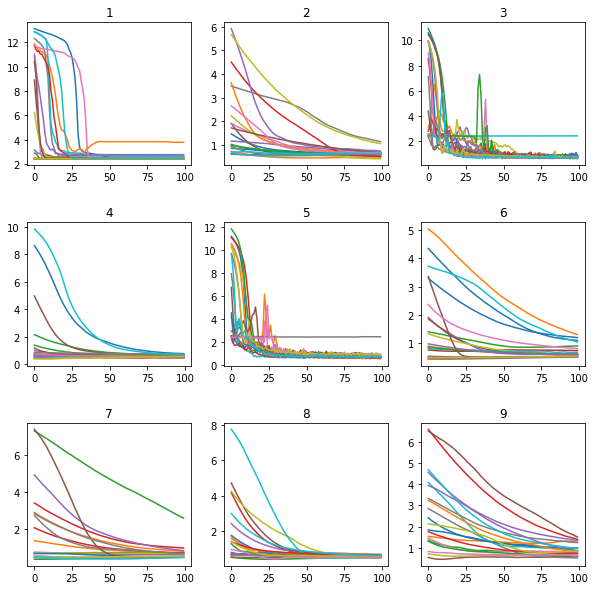

In [23]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

for i, line in enumerate(lines[:-1]):
    plt.subplot(3, 3, i + 1)
    plt.title(str(i + 1))
    
    for history in json.loads(line.split('hist: ')[1]):
        plt.plot(history)